# 비트코인 트레이딩 전략 - 딥러닝 모델 개발 과제 💰

**학생 정보**
- 이름: 
- 학번: 
- 제출일: 

---

## 📋 과제 목표

**매수/매도/홀드를 판단하는 딥러닝 모델을 개발하여 Buy and Hold 벤치마크를 초과하는 수익률을 달성하세요!**

### 과제 요구사항

1. **딥러닝 모델 개발** (핵심)
   - 매수(1), 매도(0), 홀드(2) 중 하나를 예측하는 3-class 분류 모델
   - PyTorch 사용
   - 예제 모델(LSTM) 참고 가능

2. **트레이딩 시뮬레이션** (제공됨)
   - 초기 자본: $10,000
   - 거래 수수료: 0.1%
   - 자동 평가 및 시각화

### 평가 기준

- **수익률** (70%)
  - Buy and Hold 대비 초과 수익
  - 최종 자산 가치

- **모델 설계 및 설명** (20%)
  - 아키텍처 선택 이유
  - 하이퍼파라미터 설명

- **코드 품질** (10%)
  - 코드 가독성
  - 주석 및 설명

---

## 1. 환경 설정 및 데이터 로딩

모든 데이터 로딩, 전처리, 평가 코드는 이미 제공되어 있습니다.
여러분은 **모델 아키텍처만 구현**하면 됩니다!

In [ ]:
# ========================================
# 🚀 Google Colab 사용자를 위한 설정
# ========================================
# Colab에서 실행하는 경우 이 셀을 실행하세요!

# 1. 필요한 패키지 설치
!pip install yfinance scikit-learn torch seaborn -q

# 2. utils.py 다운로드 (GitHub 저장소에서)
!wget https://raw.githubusercontent.com/juho127/TimeSeriesForecastingTest/main/utils.py -q

# 3. utils.py가 정상적으로 다운로드되었는지 확인
import os
if os.path.exists('utils.py'):
    print("✅ utils.py 다운로드 완료!")
else:
    print("❌ utils.py 다운로드 실패. 다시 시도하거나 수동으로 업로드하세요.")

# ========================================
# 로컬 환경에서 실행하는 경우:
# - 이 셀을 건너뛰고 다음 셀부터 실행하세요
# - utils.py가 같은 폴더에 있으면 자동으로 불러옵니다
# ========================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from utils import (
    load_bitcoin_data,
    create_features,
    prepare_data,
    device
)

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("✅ 라이브러리 로딩 완료!")
print(f"Using device: {device}")

In [52]:
# 데이터 로딩 및 전처리 (모두 제공됨)
start_date = "2020-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")

btc_data = load_bitcoin_data(start_date=start_date, end_date=end_date)
btc_features = create_features(btc_data, lookback_days=10)

print(f"데이터 shape: {btc_features.shape}")
print(f"특성 수: {len([c for c in btc_features.columns if c not in ['Target', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])}")

[*********************100%***********************]  1 of 1 completed

비트코인 데이터 다운로드 중: 2020-01-01 ~ 2025-11-17
다운로드 완료: 2146 행
데이터 shape: (2146, 35)
특성 수: 29


In [54]:
# 데이터 분할 및 정규화 (제공됨)
from sklearn.preprocessing import StandardScaler

X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(
    btc_features, test_size=0.2, validation_size=0.1
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"학습: {len(X_train)}, 검증: {len(X_val)}, 테스트: {len(X_test)}")

학습 데이터: 1467 샘플
검증 데이터: 209 샘플
테스트 데이터: 421 샘플
학습: 1467, 검증: 209, 테스트: 421


In [56]:
# 시퀀스 데이터 생성 (제공됨)
sequence_length = 30

def create_sequences(X, y, seq_len=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, sequence_length)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val.values, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, sequence_length)

print(f"시퀀스 데이터 shape: {X_train_seq.shape}")

시퀀스 데이터 shape: (1437, 30, 29)


In [58]:
# 타겟 변환: 2-class → 3-class (매수/매도/홀드)
def create_3class_target(y_binary, prices, volatility_threshold=0.02):
    """
    2-class 타겟을 3-class로 변환
    0: 매도, 1: 매수, 2: 홀드
    """
    y_3class = []
    for i in range(len(y_binary)):
        if i == 0:
            y_3class.append(2)  # 첫날은 홀드
            continue
        
        if i < len(prices):
            volatility = abs((prices[i] - prices[i-1]) / prices[i-1])
        else:
            volatility = 0
        
        if volatility < volatility_threshold:
            y_3class.append(2)  # 홀드
        else:
            y_3class.append(y_binary[i])  # 매수(1) 또는 매도(0)
    
    return np.array(y_3class)

# 가격 데이터 준비
test_start_idx = len(btc_features) - len(y_test)
train_prices = btc_features["Close"].iloc[:len(y_train)].squeeze().values
val_prices = btc_features["Close"].iloc[len(y_train):len(y_train)+len(y_val)].squeeze().values
test_prices = btc_features["Close"].iloc[test_start_idx:test_start_idx+len(y_test)].squeeze().values

# 3-class 타겟 생성
y_train_3class = create_3class_target(y_train_seq, train_prices[-len(y_train_seq):])
y_val_3class = create_3class_target(y_val_seq, val_prices[-len(y_val_seq):])
y_test_3class = create_3class_target(y_test_seq, test_prices[-len(y_test_seq):])

print(f"타겟 분포 (학습): 매도={np.sum(y_train_3class==0)}, 매수={np.sum(y_train_3class==1)}, 홀드={np.sum(y_train_3class==2)}")
print(f"타겟 분포 (테스트): 매도={np.sum(y_test_3class==0)}, 매수={np.sum(y_test_3class==1)}, 홀드={np.sum(y_test_3class==2)}")

타겟 분포 (학습): 매도=280, 매수=293, 홀드=864
타겟 분포 (테스트): 매도=59, 매수=63, 홀드=269


In [59]:
# DataLoader 생성 (제공됨)
train_dataset = TensorDataset(
    torch.FloatTensor(X_train_seq),
    torch.LongTensor(y_train_3class)
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(
    torch.FloatTensor(X_val_seq),
    torch.LongTensor(y_val_3class)
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(
    torch.FloatTensor(X_test_seq),
    torch.LongTensor(y_test_3class)
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("✅ DataLoader 생성 완료!")

✅ DataLoader 생성 완료!


## 2. 예제 모델: LSTM 기반 3-class 분류기

이 예제를 참고하여 자신만의 모델을 만들어보세요!

In [60]:
class ExampleLSTMModel(nn.Module):
    """
    예제: LSTM 기반 3-class 분류 모델
    매수(1), 매도(0), 홀드(2)를 예측
    """
    def __init__(self, input_size, hidden_size=64, num_classes=3):
        super(ExampleLSTMModel, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=1)
        self.dropout1 = nn.Dropout(0.2)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        
        self.lstm2 = nn.LSTM(hidden_size, hidden_size//2, batch_first=True, num_layers=1)
        self.dropout2 = nn.Dropout(0.2)
        self.bn2 = nn.BatchNorm1d(hidden_size//2)
        
        self.fc1 = nn.Linear(hidden_size//2, 32)
        self.relu = nn.ReLU()
        self.dropout3 = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(32, num_classes)
        
    def forward(self, x):
        lstm_out, _ = self.lstm1(x)
        lstm_out = self.dropout1(lstm_out)
        lstm_out = lstm_out.permute(0, 2, 1)
        lstm_out = self.bn1(lstm_out)
        lstm_out = lstm_out.permute(0, 2, 1)
        
        lstm_out, _ = self.lstm2(lstm_out)
        lstm_out = self.dropout2(lstm_out[:, -1, :])
        lstm_out = self.bn2(lstm_out)
        
        out = self.fc1(lstm_out)
        out = self.relu(out)
        out = self.dropout3(out)
        
        out = self.fc2(out)
        return out

# 예제 모델 생성
example_model = ExampleLSTMModel(
    input_size=X_train_seq.shape[2],
    hidden_size=64,
    num_classes=3
).to(device)

print("예제 모델 구조:")
print(example_model)
print(f"\nTotal parameters: {sum(p.numel() for p in example_model.parameters()):,}")

예제 모델 구조:
ExampleLSTMModel(
  (lstm1): LSTM(29, 64, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm2): LSTM(64, 32, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32, out_features=32, bias=True)
  (relu): ReLU()
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=32, out_features=3, bias=True)
)

Total parameters: 38,211


In [61]:
# 예제 모델 학습 함수 (제공됨)
def train_model(model, train_loader, val_loader, epochs=50, lr=0.001, patience=10):
    """
    모델 학습 함수
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
        
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
        #else:
        # else:
            
        # 
        #     break
    
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return history

print("✅ 학습 함수 준비 완료!")

✅ 학습 함수 준비 완료!


예제 모델 학습 시작...
예제 모델 학습 시작...
Epoch [10/50], Train Loss: 0.8896, Val Loss: 1.0057, Train Acc: 0.6019, Val Acc: 0.5866
Epoch [20/50], Train Loss: 0.8229, Val Loss: 1.0822, Train Acc: 0.6228, Val Acc: 0.5642
Early stopping at epoch 23
✅ 예제 모델 학습 완료!


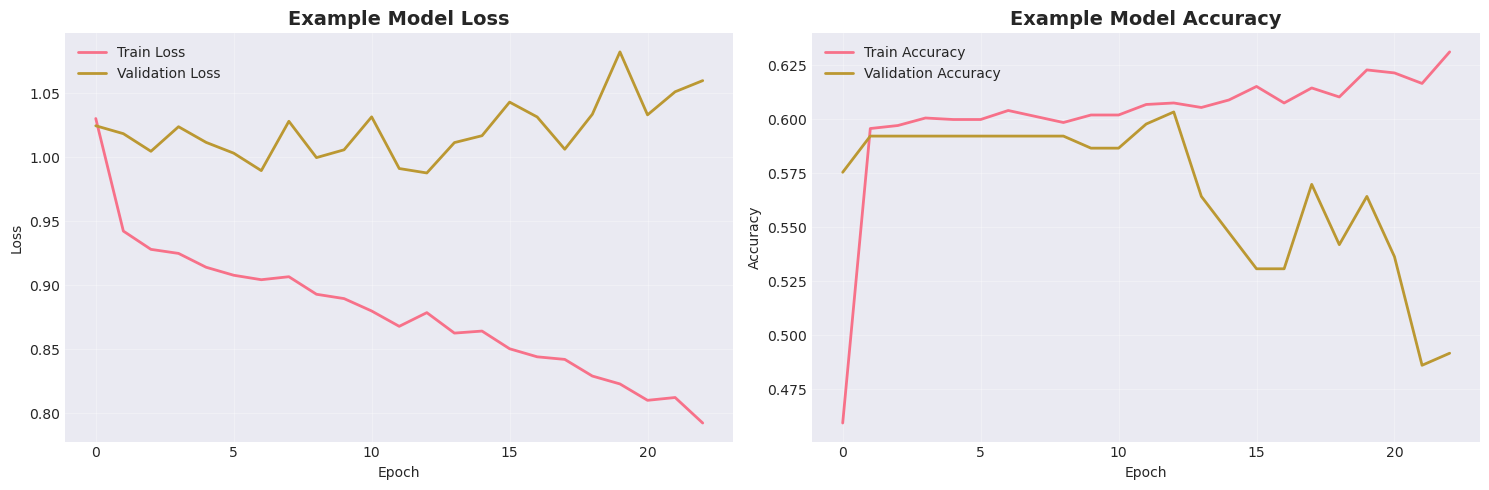

In [62]:
# 예제 모델 학습 (참고용 - 바로 실행 가능)
print("예제 모델 학습 시작...")
# 예제 모델 학습 (참고용 - 바로 실행 가능)
# patience: early stopping patience 값 (기본값: 10, 값이 클수록 더 오래 기다림)
print("예제 모델 학습 시작...")
example_history = train_model(example_model, train_loader, val_loader, epochs=50, lr=0.001, patience=10)
print("✅ 예제 모델 학습 완료!")

# 학습 과정 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(example_history["train_loss"], label="Train Loss", linewidth=2)
axes[0].plot(example_history["val_loss"], label="Validation Loss", linewidth=2)
axes[0].set_title("Example Model Loss", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[1].plot(example_history["train_acc"], label="Train Accuracy", linewidth=2)
axes[1].plot(example_history["val_acc"], label="Validation Accuracy", linewidth=2)
axes[1].set_title("Example Model Accuracy", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2-1. 예제 모델 전체 파이프라인 실행 📊

예제 모델의 전체 과정을 한번에 실행합니다:
1. 예측 생성
2. 트레이딩 시뮬레이션
3. Buy and Hold 벤치마크 계산
4. 성능 비교 및 시각화

이 결과를 참고하여 자신만의 모델을 개발하세요!

In [66]:
# 예측 함수 (제공됨)
def predict_model(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch_X, _ in data_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            predictions.append(predicted.cpu().numpy())
    return np.concatenate(predictions)

# TODO: 자신의 모델로 예측 (아래 주석 해제 후 사용)
# ⚠️ 주의: 먼저 MyTradingModel 클래스를 구현하고 모델을 생성해야 합니다!
# my_predictions = predict_model(my_model, test_loader)
# my_predictions = predict_model(my_model, test_loader)
# print(f"예측 완료! 예측 수: {len(my_predictions)}")
# print(f"예측 분포: 매도={np.sum(my_predictions==0)}, 매수={np.sum(my_predictions==1)}, 홀드={np.sum(my_predictions==2)}")

NameError: name 'my_model' is not defined

In [ ]:
# 트레이딩 시뮬레이션 함수 (제공됨)
def simulate_trading_3class(predictions, actual_prices, dates, initial_capital=10000, transaction_fee=0.001):
    """
    3-class 예측을 기반으로 트레이딩 시뮬레이션
    0: 매도, 1: 매수, 2: 홀드
    """
    cash = initial_capital
    btc_holdings = 0
    portfolio_values = []
    trade_log = []
    
    for i in range(len(predictions)):
        current_price = actual_prices[i]
        pred = predictions[i]
        portfolio_value = cash + btc_holdings * current_price
        portfolio_values.append(portfolio_value)
        
        if i == len(predictions) - 1:
            if btc_holdings > 0:
                sell_value = btc_holdings * current_price * (1 - transaction_fee)
                cash += sell_value
                btc_holdings = 0
            continue
        
        if pred == 1:  # 매수
            if cash > 0:
                buy_amount = (cash * (1 - transaction_fee)) / current_price
                btc_holdings += buy_amount
                cash = 0
        elif pred == 0:  # 매도
            if btc_holdings > 0:
                sell_value = btc_holdings * current_price * (1 - transaction_fee)
                cash += sell_value
                btc_holdings = 0
    
    final_value = portfolio_values[-1]
    total_return = (final_value - initial_capital) / initial_capital * 100
    
    return {
        'initial_capital': initial_capital,
        'final_value': final_value,
        'total_return': total_return,
        'portfolio_values': portfolio_values,
        'num_trades': len([p for p in predictions if p != 2])
    }

print("✅ 트레이딩 시뮬레이션 함수 준비 완료!")

In [50]:
# ============================================
# 예제 모델 전체 파이프라인: 예측 → 시뮬레이션 → Buy and Hold 비교
# ============================================

# 1. 예제 모델 예측
example_predictions = predict_model(example_model, test_loader)
print(f"예제 모델 예측 완료! 예측 수: {len(example_predictions)}")
print(f"예측 분포: 매도={np.sum(example_predictions==0)}, 매수={np.sum(example_predictions==1)}, 홀드={np.sum(example_predictions==2)}")

# 2. 트레이딩 시뮬레이션을 위한 데이터 준비
test_start_idx = len(btc_features) - len(y_test) + sequence_length
test_prices_aligned = btc_features["Close"].iloc[test_start_idx:test_start_idx+len(y_test_3class)].squeeze().values
test_dates_aligned = btc_features.index[test_start_idx:test_start_idx+len(y_test_3class)]

# 3. 예제 모델 트레이딩 시뮬레이션
example_trading_result = simulate_trading_3class(
    predictions=example_predictions,
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=10000,
    transaction_fee=0.001
)

print("\n" + "="*70)
print("예제 모델 트레이딩 결과")
print("="*70)
print(f"초기 자본: ${example_trading_result['initial_capital']:,.2f}")
print(f"최종 자본: ${example_trading_result['final_value']:,.2f}")
print(f"수익률: {example_trading_result['total_return']:.2f}%")
print(f"거래 횟수: {example_trading_result['num_trades']}회")
print("="*70)

# 4. Buy and Hold 벤치마크 계산
initial_price = test_prices_aligned[0]
coins_bought = 10000 / initial_price
buy_hold_final_value = coins_bought * test_prices_aligned[-1] * (1 - 0.001)
buy_hold_return = (buy_hold_final_value - 10000) / 10000 * 100
buy_hold_portfolio = [coins_bought * price for price in test_prices_aligned]

print("\n" + "="*70)
print("Buy and Hold 벤치마크")
print("="*70)
print(f"시작 가격: ${initial_price:,.2f}")
print(f"종료 가격: ${test_prices_aligned[-1]:,.2f}")
print(f"초기 자본: $10,000.00")
print(f"최종 자본: ${buy_hold_final_value:,.2f}")
print(f"수익률: {buy_hold_return:.2f}%")
print("="*70)

# 5. 예제 모델 vs Buy and Hold 비교
print("\n" + "="*70)
print("예제 모델 vs Buy and Hold 비교")
print("="*70)
print(f"Buy and Hold: {buy_hold_return:.2f}%")
print(f"예제 모델: {example_trading_result['total_return']:.2f}%")
print(f"초과 수익: {example_trading_result['total_return'] - buy_hold_return:.2f}%p")
print("="*70)

# 6. 시각화
all_results = {
    "Buy and Hold (Benchmark)": {
        "initial_capital": 10000,
        "final_value": buy_hold_final_value,
        "total_return": buy_hold_return,
        "portfolio_values": buy_hold_portfolio,
        "num_trades": 2,
        "dates": test_dates_aligned
    },
    "Example Model": {
        "initial_capital": example_trading_result["initial_capital"],
        "final_value": example_trading_result["final_value"],
        "total_return": example_trading_result["total_return"],
        "portfolio_values": example_trading_result["portfolio_values"],
        "num_trades": example_trading_result["num_trades"],
        "dates": test_dates_aligned
    }
}

fig, axes = plt.subplots(2, 1, figsize=(15, 10))
axes[0].plot(test_dates_aligned, buy_hold_portfolio, 
            label=f"Buy and Hold ({buy_hold_return:.2f}%)", 
            linewidth=2.5, linestyle="--", color="black", alpha=0.7)
axes[0].plot(test_dates_aligned, example_trading_result["portfolio_values"], 
            label=f"Example Model ({example_trading_result['total_return']:.2f}%)", 
            linewidth=2, color="blue")
axes[0].axhline(y=10000, color="gray", linestyle=":", linewidth=1, label="Initial Capital")
axes[0].set_title("Portfolio Value Over Time", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Portfolio Value ($)")
axes[0].set_xlabel("Date")
axes[0].legend()
axes[0].grid(True, alpha=0.3)
strategies = ["Buy and Hold", "Example Model"]
returns = [buy_hold_return, example_trading_result['total_return']]
colors = ['green' if r > 0 else 'red' for r in returns]
axes[1].bar(strategies, returns, color=colors, alpha=0.7)
axes[1].axhline(y=0, color="black", linestyle="-", linewidth=1)
axes[1].set_title("Total Return Comparison", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Return (%)")
axes[1].grid(axis="y", alpha=0.3)
for i, (strategy, ret) in enumerate(zip(strategies, returns)):
    axes[1].text(i, ret, f'{ret:.2f}%', ha='center', 
                va='bottom' if ret > 0 else 'top', fontweight='bold')
plt.tight_layout()
plt.show()


예제 모델 예측 완료! 예측 수: 391
예측 분포: 매도=22, 매수=118, 홀드=251


NameError: name 'simulate_trading_3class' is not defined

---

## 3. 자신만의 모델 개발 ⭐

### 📝 모델 설계 설명

**TODO: 아래에 자신의 모델 선택 이유와 설계 과정을 설명하세요**

```
여기에 작성:

1. 모델 아키텍처:
   - 

2. 선택 이유:
   - 

3. 하이퍼파라미터:
   - hidden_size: 
   - learning_rate: 
   - dropout: 

4. 예제 모델과의 차별점:
   - 
```

---

In [ ]:
# TODO: 자신만의 모델 구현
# ============================================
# 힌트: 아래 예제 모델 코드를 복사해서 수정하세요!
# ============================================

class MyTradingModel(nn.Module):
    """
    자신만의 트레이딩 모델
    입력: (batch, sequence_length, features)
    출력: (batch, 3) - [매도 확률, 매수 확률, 홀드 확률]
    """
    def __init__(self, input_size, num_classes=3):
        super(MyTradingModel, self).__init__()
        
        # ============================================
        # 예제 모델 코드 (참고용 - 복사해서 수정하세요)
        # ============================================
        # self.lstm1 = nn.LSTM(input_size, 64, batch_first=True, num_layers=1)
        # self.dropout1 = nn.Dropout(0.2)
        # self.bn1 = nn.BatchNorm1d(64)
        # self.lstm2 = nn.LSTM(64, 32, batch_first=True, num_layers=1)
        # self.dropout2 = nn.Dropout(0.2)
        # self.bn2 = nn.BatchNorm1d(32)
        # self.fc1 = nn.Linear(32, 32)
        # self.relu = nn.ReLU()
        # self.dropout3 = nn.Dropout(0.2)
        # self.fc2 = nn.Linear(32, num_classes)
        # ============================================
        
        # TODO: 위 예제 코드를 복사해서 아래에 붙여넣고 수정하세요
        # 아이디어:
        # - LSTM 대신 GRU 사용
        # - 더 많은/적은 레이어 추가
        # - Hidden size 변경
        # - CNN 레이어 추가
        # - Attention mechanism 추가
        # - Residual connections 추가
        
        pass  # TODO: 구현하세요
    
    def forward(self, x):
        # ============================================
        # 예제 모델 forward 코드 (참고용)
        # ============================================
        # lstm_out, _ = self.lstm1(x)
        # lstm_out = self.dropout1(lstm_out)
        # lstm_out = lstm_out.permute(0, 2, 1)
        # lstm_out = self.bn1(lstm_out)
        # lstm_out = lstm_out.permute(0, 2, 1)
        # lstm_out, _ = self.lstm2(lstm_out)
        # lstm_out = self.dropout2(lstm_out[:, -1, :])
        # lstm_out = self.bn2(lstm_out)
        # out = self.fc1(lstm_out)
        # out = self.relu(out)
        # out = self.dropout3(out)
        # out = self.fc2(out)
        # return out
        # ============================================
        
        # TODO: 위 예제 코드를 복사해서 아래에 붙여넣고 수정하세요
        pass  # TODO: 구현하세요

# ============================================
# ⚠️ 중요: MyTradingModel 클래스를 먼저 구현해야 합니다!
# 위의 __init__과 forward 메서드를 완성한 후 아래 주석을 해제하세요.
# ============================================
# 모델 생성 (주석 해제 후 사용)
# my_model = MyTradingModel(
#     input_size=X_train_seq.shape[2],
#     num_classes=3
# ).to(device)

# print("나의 모델 구조:")
# print(my_model)
# print(f"\nTotal parameters: {sum(p.numel() for p in my_model.parameters()):,}")

In [ ]:
# TODO: 모델 학습
# TODO: 모델 학습
# patience: early stopping patience 값 조절 가능 (기본값: 10)
#         - 작은 값 (5): 빠르게 중단, 과적합 방지
#         - 큰 값 (20): 더 오래 학습, 더 나은 성능 가능
# my_history = train_model(
#     model=my_model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     epochs=50,
#     lr=0.001,
#     patience=10  # early stopping patience 값 조절 가능
# )

# print("✅ 모델 학습 완료!")

In [ ]:
# TODO: 학습 과정 시각화 (선택사항)
# fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# axes[0].plot(my_history["train_loss"], label="Train Loss", linewidth=2)
# axes[0].plot(my_history["val_loss"], label="Validation Loss", linewidth=2)
# axes[0].set_title("Model Loss", fontsize=14, fontweight="bold")
# axes[0].set_xlabel("Epoch")
# axes[0].set_ylabel("Loss")
# axes[0].legend()
# axes[0].grid(True, alpha=0.3)
# axes[1].plot(my_history["train_acc"], label="Train Accuracy", linewidth=2)
# axes[1].plot(my_history["val_acc"], label="Validation Accuracy", linewidth=2)
# axes[1].set_title("Model Accuracy", fontsize=14, fontweight="bold")
# axes[1].set_xlabel("Epoch")
# axes[1].set_ylabel("Accuracy")
# axes[1].legend()
# axes[1].grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

## 4. 예측 및 트레이딩 시뮬레이션 (제공됨)

모든 평가 코드는 이미 준비되어 있습니다!

In [ ]:
# TODO: 자신의 모델로 트레이딩 시뮬레이션 (아래 주석 해제 후 사용)
# ⚠️ 주의: 먼저 모델을 학습하고 예측을 생성해야 합니다!
test_start_idx = len(btc_features) - len(y_test) + sequence_length
test_prices_aligned = btc_features["Close"].iloc[test_start_idx:test_start_idx+len(y_test_3class)].squeeze().values
test_dates_aligned = btc_features.index[test_start_idx:test_start_idx+len(y_test_3class)]

# my_trading_result = simulate_trading_3class(
#     predictions=my_predictions,
#     actual_prices=test_prices_aligned,
#     dates=test_dates_aligned,
#     initial_capital=10000,
#     transaction_fee=0.001
# )

# print("\n" + "="*70)
# print("나의 트레이딩 전략 결과")
# print("="*70)
# print(f"초기 자본: ${my_trading_result['initial_capital']:,.2f}")
# print(f"최종 자본: ${my_trading_result['final_value']:,.2f}")
# print(f"수익률: {my_trading_result['total_return']:.2f}%")
# print(f"거래 횟수: {my_trading_result['num_trades']}회")
# print("="*70)

## 2-2. 자신의 모델 vs Buy and Hold 비교 ⭐

아래 코드를 주석 해제하여 자신의 모델을 Buy and Hold와 비교하세요!

In [ ]:
# Buy and Hold 벤치마크 계산 (제공됨)
initial_price = test_prices_aligned[0]
coins_bought = 10000 / initial_price
buy_hold_final_value = coins_bought * test_prices_aligned[-1] * (1 - 0.001)
buy_hold_return = (buy_hold_final_value - 10000) / 10000 * 100

buy_hold_portfolio = [coins_bought * price for price in test_prices_aligned]

print("\n" + "="*70)
print("Buy and Hold 벤치마크")
print("="*70)
print(f"시작 가격: ${initial_price:,.2f}")
print(f"종료 가격: ${test_prices_aligned[-1]:,.2f}")
print(f"초기 자본: $10,000.00")
print(f"최종 자본: ${buy_hold_final_value:,.2f}")
print(f"수익률: {buy_hold_return:.2f}%")
print("="*70)

In [ ]:
# ============================================
# 자신의 모델: 예측 → 시뮬레이션 → Buy and Hold 비교
# ============================================
# ⚠️ 주의: 아래 코드는 MyTradingModel을 구현하고 학습한 후 주석을 해제하세요!

# 1. 자신의 모델 예측 (주석 해제 후 사용)
# my_predictions = predict_model(my_model, test_loader)
# print(f"나의 모델 예측 완료! 예측 수: {len(my_predictions)}")
# print(f"예측 분포: 매도={np.sum(my_predictions==0)}, 매수={np.sum(my_predictions==1)}, 홀드={np.sum(my_predictions==2)}")

# 2. 자신의 모델 트레이딩 시뮬레이션 (주석 해제 후 사용)
# my_trading_result = simulate_trading_3class(
#     predictions=my_predictions,
#     actual_prices=test_prices_aligned,
#     dates=test_dates_aligned,
#     initial_capital=10000,
#     transaction_fee=0.001
# )

# print("\n" + "="*70)
# print("나의 모델 트레이딩 결과")
# print("="*70)
# print(f"초기 자본: ${my_trading_result['initial_capital']:,.2f}")
# print(f"최종 자본: ${my_trading_result['final_value']:,.2f}")
# print(f"수익률: {my_trading_result['total_return']:.2f}%")
# print(f"거래 횟수: {my_trading_result['num_trades']}회")
# print("="*70)

# 3. 자신의 모델 vs Buy and Hold 비교 (주석 해제 후 사용)
# print("\n" + "="*70)
# print("나의 모델 vs Buy and Hold 비교")
# print("="*70)
# print(f"Buy and Hold: {buy_hold_return:.2f}%")
# print(f"나의 모델: {my_trading_result['total_return']:.2f}%")
# print(f"초과 수익: {my_trading_result['total_return'] - buy_hold_return:.2f}%p")
# print("="*70)

# 4. 시각화: Buy and Hold vs 예제 모델 vs 나의 모델 (주석 해제 후 사용)
# all_results_with_mine = {
#     "Buy and Hold (Benchmark)": {
#         "initial_capital": 10000,
#         "final_value": buy_hold_final_value,
#         "total_return": buy_hold_return,
#         "portfolio_values": buy_hold_portfolio,
#         "num_trades": 2,
#         "dates": test_dates_aligned
#     },
#     "Example Model": {
#         "initial_capital": example_trading_result["initial_capital"],
#         "final_value": example_trading_result["final_value"],
#         "total_return": example_trading_result["total_return"],
#         "portfolio_values": example_trading_result["portfolio_values"],
#         "num_trades": example_trading_result["num_trades"],
#         "dates": test_dates_aligned
#     },
#     "My Model": {
#         "initial_capital": my_trading_result["initial_capital"],
#         "final_value": my_trading_result["final_value"],
#         "total_return": my_trading_result["total_return"],
#         "portfolio_values": my_trading_result["portfolio_values"],
#         "num_trades": my_trading_result["num_trades"],
#         "dates": test_dates_aligned
#     }
# }

# fig, axes = plt.subplots(2, 1, figsize=(15, 10))
# axes[0].plot(test_dates_aligned, buy_hold_portfolio, 
#             label=f"Buy and Hold ({buy_hold_return:.2f}%)", 
#             linewidth=2.5, linestyle="--", color="black", alpha=0.7)
# axes[0].plot(test_dates_aligned, example_trading_result["portfolio_values"], 
#             label=f"Example Model ({example_trading_result['total_return']:.2f}%)", 
#             linewidth=2, color="blue", alpha=0.7)
# axes[0].plot(test_dates_aligned, my_trading_result["portfolio_values"], 
#             label=f"My Model ({my_trading_result['total_return']:.2f}%)", 
#             linewidth=2, color="red")
# axes[0].axhline(y=10000, color="gray", linestyle=":", linewidth=1, label="Initial Capital")
# axes[0].set_title("Portfolio Value Over Time", fontsize=14, fontweight="bold")
# axes[0].set_ylabel("Portfolio Value ($)")
# axes[0].set_xlabel("Date")
# axes[0].legend()
# axes[0].grid(True, alpha=0.3)
# strategies = ["Buy and Hold", "Example Model", "My Model"]
# returns = [buy_hold_return, example_trading_result['total_return'], my_trading_result['total_return']]
# colors = ['green' if r > 0 else 'red' for r in returns]
# axes[1].bar(strategies, returns, color=colors, alpha=0.7)
# axes[1].axhline(y=0, color="black", linestyle="-", linewidth=1)
# axes[1].set_title("Total Return Comparison", fontsize=14, fontweight="bold")
# axes[1].set_ylabel("Return (%)")
# axes[1].grid(axis="y", alpha=0.3)
# for i, (strategy, ret) in enumerate(zip(strategies, returns)):
#     axes[1].text(i, ret, f'{ret:.2f}%', ha='center', 
#                 va='bottom' if ret > 0 else 'top', fontweight='bold')
# plt.tight_layout()
# plt.show()


In [ ]:
# TODO: 결과 비교 및 시각화
# all_results = {
#     "Buy and Hold": {
#         "initial_capital": 10000,
#         "final_value": buy_hold_final_value,
#         "total_return": buy_hold_return,
#         "portfolio_values": buy_hold_portfolio,
#         "num_trades": 2,
#         "dates": test_dates_aligned
#     },
#     "My Strategy": my_trading_result
# }

# print("\n" + "="*70)
# print("수익률 비교")
# print("="*70)
# print(f"Buy and Hold: {buy_hold_return:.2f}%")
# print(f"My Strategy: {my_trading_result['total_return']:.2f}%")
# print(f"초과 수익: {my_trading_result['total_return'] - buy_hold_return:.2f}%p")
# print("="*70)

# fig, axes = plt.subplots(2, 1, figsize=(15, 10))
# axes[0].plot(test_dates_aligned, buy_hold_portfolio, 
#             label=f"Buy and Hold ({buy_hold_return:.2f}%)", 
#             linewidth=2.5, linestyle="--", color="black", alpha=0.7)
# axes[0].plot(test_dates_aligned, my_trading_result["portfolio_values"], 
#             label=f"My Strategy ({my_trading_result['total_return']:.2f}%)", 
#             linewidth=2, color="blue")
# axes[0].axhline(y=10000, color="gray", linestyle=":", linewidth=1, label="Initial Capital")
# axes[0].set_title("Portfolio Value Over Time", fontsize=14, fontweight="bold")
# axes[0].set_ylabel("Portfolio Value ($)")
# axes[0].set_xlabel("Date")
# axes[0].legend()
# axes[0].grid(True, alpha=0.3)
# strategies = ["Buy and Hold", "My Strategy"]
# returns = [buy_hold_return, my_trading_result['total_return']]
# colors = ['green' if r > 0 else 'red' for r in returns]
# axes[1].bar(strategies, returns, color=colors, alpha=0.7)
# axes[1].axhline(y=0, color="black", linestyle="-", linewidth=1)
# axes[1].set_title("Total Return Comparison", fontsize=14, fontweight="bold")
# axes[1].set_ylabel("Return (%)")
# axes[1].grid(axis="y", alpha=0.3)
# for i, (strategy, ret) in enumerate(zip(strategies, returns)):
#     axes[1].text(i, ret, f'{ret:.2f}%', ha='center', 
#                 va='bottom' if ret > 0 else 'top', fontweight='bold')
# plt.tight_layout()
# plt.show()

---

## 6. 결과 분석 및 고찰 📊

### 📝 작성 가이드

#### 1. 모델 성능 분석
- Buy and Hold 대비 수익률은 어떠한가요?
- 어떤 시기에 좋은/나쁜 성과를 보였나요?
- 예측 분포 (매수/매도/홀드 비율)는 적절했나요?

#### 2. 모델 설계
- 왜 이 아키텍처를 선택했나요?
- 하이퍼파라미터 튜닝 과정은?
- 예제 모델과 어떤 차이가 있나요?

#### 3. 개선 방향
- 모델의 한계점은?
- 추가로 시도해보고 싶은 방법은?

---

### ✍️ 답변 작성

**1. 모델 성능 분석**

```
여기에 답변을 작성하세요.
```

**2. 모델 설계**

```
여기에 답변을 작성하세요.
```

**3. 개선 방향**

```
여기에 답변을 작성하세요.
```

---

## ✅ 과제 체크리스트

- [ ] 학생 정보 (이름, 학번) 작성
- [ ] MyTradingModel 클래스 구현 완료
- [ ] 모델 학습 완료
- [ ] 트레이딩 시뮬레이션 실행 및 결과 확인
- [ ] Buy and Hold와 비교 분석
- [ ] 결과 분석 및 고찰 작성
- [ ] 코드에 충분한 주석 추가

### 평가 기준

1. **수익률 (70%)** - Buy and Hold 벤치마크 대비 수익
2. **모델 설계 및 설명 (20%)** - 아키텍처 선택 이유, 하이퍼파라미터
3. **코드 품질 (10%)** - 가독성, 주석, 설명

---

**과제를 완성하셨습니다! 수고하셨습니다! 🎉**